# Spiking Jelly

In [1]:
import spikingjelly as sj
import numpy as np
import torch

## 1. 基本概念

### 1.1 数据格式
* 单个时刻的数据：shape=[B, *], B 为 batch size
* 多个时刻的数据：shape=[T, B, *], T 为时间步数

### 1.2 步进模式
* 单步模式(single-step)：使用单个时刻的数据格式
* 多步模式(multi-step)：使用多个时刻的数据格式


In [2]:
from spikingjelly.activation_based import neuron
# multi-step mode
net = neuron.IFNode(step_mode='m')
# single-step mode
net.step_mode = 's'

In [3]:
# 将多时刻数据输入进单步模式
from spikingjelly.activation_based import functional
T = 4
B = 1
C = 3
H = 8
W = 8
x_seq = torch.rand([T, B, C, H, W])
y_seq = functional.multi_step_forward(x_seq, net)

### 1.3 状态的保存和重置
activation_base 中，状态会保存在模块内部

In [4]:
net = neuron.IFNode(step_mode='s')
x = torch.rand([4])
print(net)
print(f'默认电压: {net.v}')
y = net(x)
print(f'x={x}')
print(f'y={y}')
print(f'v={net.v}')

IFNode(
  v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
  (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
)
默认电压: 0.0
x=tensor([0.1172, 0.8994, 0.2742, 0.6098])
y=tensor([0., 0., 0., 0.])
v=tensor([0.1172, 0.8994, 0.2742, 0.6098])


In [5]:
# 如果要再次输入，需要先清除神经元之前的状态
net.reset()
print(f'reset_v={net.v}')
x = torch.rand([8])
y = net(x)
print(f'v={net.v}')

reset_v=0.0
v=tensor([0.9423, 0.0796, 0.8632, 0.8600, 0.1194, 0.5751, 0.8858, 0.4663])


所以在使用有状态的模块时，在处理完一个 batch 的数据后，务必进行重置
```python
for x, label in tqdm(train_data_loader):
    # ...
    optimizer.zero_grad()
    y = net(x)
    loss = criterion(y, label)
    loss.backward()
    optimizer.step()

    functional.reset_net(net)
```

### 1.4 传播模式
* 如果一个网络全部由单步模块组成，则整个网络的计算顺序是按照逐步传播(step-by-step)的模式进行的
```python
for t in range(T):
    x = x_seq[t]
    y = net(x)
    y_seq_step_by_step.append(y.unsqueeze(0))
y_seq_step_by_step = torch.cat(y_seq_step_by_step, dim=0)
```
<img src="images/step-by-step.png">

* 如果网络全部由多步模块组成，则整个网络的计算顺序是按照逐层传播(layer-by-layer)的模式进行的
```python
import torch
x_seq = torch.rand([T, B, C]) * 64.
net = nn.Sequential(
    layer.Linear(C, 4),
    neuron.IFNode(),
    layer.Linear(4, 2),
    neuron.IFNode()
)
functional.set_step_mode(net, step_mode='m')
with torch.no_grad():
    y_seq_layer_by_layer = x_seq
    for i in range(net.__len__()):
        y_seq_layer_by_layer = net[i](y_seq_layer_by_layer)
```
<img src="images/layer-by-layer.png">

SNN 计算图有 2 个维度，分别为时间步数和网络深度，两种计算顺序在计算速度和内存消耗上会略有区别
* 在使用梯度替代法训练时，通常使用逐层传播，因为逐层传播的并行度更大，速度更快
* 在内存受限时，使用逐步传播。因为在逐层传播模式下，无状态的层真正的 batch_size=T*B, 而不是 B。

In [6]:
# 逐步传播和逐层传播只是计算顺序不同，并不影响计算结果
import torch
import torch.nn as nn
from spikingjelly.activation_based import neuron, functional, layer
T = 4
B = 2
C = 3
H = 8
W = 8
x_seq = torch.rand([T, B, C, H, W]) * 64.

net = nn.Sequential(
    layer.Conv2d(C, 8, kernel_size=3, padding=1, stride=1, bias=False),
    neuron.IFNode(),     # 默认为单步模式
    layer.MaxPool2d(kernel_size=2, stride=2),
    neuron.IFNode(),
    layer.Flatten(start_dim=1),
    layer.Linear(8 * H // 2 * W // 2, 10),
    neuron.IFNode(),
)
print(f'net={net}')

with torch.no_grad():
    y_seq_step_by_step = []
    for t in range(T):
        x = x_seq[t]
        y = net(x)
        y_seq_step_by_step.append(y.unsqueeze(0))
    y_seq_step_by_step = torch.cat(y_seq_step_by_step, dim=0)

    print(f'y_seq_step_by_step=\n{y_seq_step_by_step}')
    functional.reset_net(net)
    functional.set_step_mode(net, step_mode='m')
    y_seq_layer_by_layer = net(x_seq)
    
    max_error = (y_seq_layer_by_layer - y_seq_step_by_step).max()
    print(f'max_error={max_error}')

net=Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, step_mode=s)
  (1): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, step_mode=s)
  (3): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1, step_mode=s)
  (5): Linear(in_features=128, out_features=10, bias=True)
  (6): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
)
y_seq_step_by_step=
tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 1., 0

## 2. 包装器
* 函数风格的：multi_step_forward, seq_to_ann_forward
* 模块风格的：MultiStepContainer, SeqToAnnContainer
* 对单步模块进行包装以进行单步/多步模式传播的：StepModeContainer

In [8]:
net_s = neuron.IFNode(step_mode='s')
T = 4
B = 1
C = 3
H = 8
W = 8
x_seq = torch.rand([T, B, C, H, W])
# multi_step_forward 可以将一个单步模块进行多步传播
y_seq = functional.multi_step_forward(x_seq, net_s)
print(f'y_seq={y_seq.shape}')

net_s.reset()
# MultiStepContainer 可以将一个单步模块包装成多步模块
net_m = layer.MultiStepContainer(net_s)
z_seq = net_m(x_seq)
print(f'z_seq={z_seq.shape}')

  v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
  (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
) supports for step_mode == 's', which should not be contained by MultiStepContainer!


y_seq=torch.Size([4, 1, 3, 8, 8])
z_seq=torch.Size([4, 1, 3, 8, 8])


In [9]:
# 对于无状态的 ANN 网络层，可以用多步包装器进行包装以用于多步模式
with torch.no_grad():
    x_seq = torch.rand([T, B, C, H, W])
    
    conv = layer.Conv2d(C, 8, kernel_size=3, padding=1, bias=False)
    bn = nn.BatchNorm2d(8)
    
    y_seq = functional.multi_step_forward(x_seq, (conv, bn))
    print(f'y_seq={y_seq.shape}')
    
    net = layer.MultiStepContainer(conv, bn)
    z_seq = net(x_seq)
    print(f'z_seq={z_seq.shape}')

y_seq=torch.Size([4, 1, 8, 8, 8])
z_seq=torch.Size([4, 1, 8, 8, 8])


In [12]:
# 但是 ANN 网络层本身并不存在前序依赖，没有必要在时间上进行串行计算
# 所以可以使用 seq_to_ann_forward 或 SeqToAnnContainer 进行包装
with torch.no_grad():
    x_seq = torch.rand([T, B, C, H, W])
    
    conv = layer.Conv2d(C, 8, kernel_size=3, padding=1, bias=False)
    bn = nn.BatchNorm2d(8)
    
    y_seq = functional.multi_step_forward(x_seq, (conv, bn))
    print(f'y_seq={y_seq.shape}')
    
    net = layer.MultiStepContainer(conv, bn)
    z_seq = net(x_seq)
    print(f'z_seq={z_seq.shape}')
    
    p_seq = functional.seq_to_ann_forward(x_seq, (conv, bn))
    print(f'p_seq={p_seq.shape}')
    
    net = layer.SeqToANNContainer(conv, bn)
    q_seq = net(x_seq)
    print(f'q_seq={q_seq.shape}')

y_seq=torch.Size([4, 1, 8, 8, 8])
z_seq=torch.Size([4, 1, 8, 8, 8])
p_seq=torch.Size([4, 1, 8, 8, 8])
q_seq=torch.Size([4, 1, 8, 8, 8])


**上面的代码会报 Warning 是因为 MultiStepContainer 和 SeqToAnnContainer 只支持多步模式，不允许切换为单步模式，所以不推荐手动包装，而是使用 layer 中已经实现了的常用网络层**

In [13]:
# StepModeContainer 可以用于包装无状态和有状态的单步模块，但需要在包装时指明是否有状态，不过此包装器支持单步模式和多步模式的切换
# 无状态层
with torch.no_grad():
    x_seq = torch.rand([T, B, C, H, W])
    net = layer.StepModeContainer(
        False,
        nn.Conv2d(C, C, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(C),
    )
    net.step_mode = 'm'
    y_seq = net(x_seq)
    print(f'y_seq={y_seq.shape}')
    
    net.step_mode ='s'
    y = net(x_seq[0])
    print(f'y={y.shape}')

y_seq=torch.Size([4, 1, 3, 8, 8])
y=torch.Size([1, 3, 8, 8])


In [14]:
# 有状态层
with torch.no_grad():
    x_seq = torch.rand([T, B, C, H, W])
    net = layer.StepModeContainer(
        True,
        neuron.IFNode(),
    )
    net.step_mode = 'm'
    y_seq = net(x_seq)
    print(f'y_seq={y_seq.shape}')
    functional.reset_net(net)
    
    net.step_mode ='s'
    y = net(x_seq[0])
    print(f'y={y.shape}')
    functional.reset_net(net)    

  v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
  (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
) supports for step_mode == 's', which should not be contained by StepModeContainer!


y_seq=torch.Size([4, 1, 3, 8, 8])
y=torch.Size([1, 3, 8, 8])


**此代码会 Warning 是因为模块本身就支持单步和多步的切换，不推荐用 MultiStepContainer 或 StepModeContainer 进行包装，因为包装器使用的多步前向传播可能不如模块自身定义的前向传播快。**

**需要用到 MultiStepContainer 或 StepModeContainer 的是一些没有定义多步 的模块，如一个在 torch.nn 中存在，而在 layer 中不存在的网络层。**

## 3. 神经元

### 3.1 脉冲神经元模型

In [15]:
import torch
from spikingjelly.activation_based import neuron
from spikingjelly import visualizing
from matplotlib import pyplot as plt

#### 3.1.1 IF 神经元模型

neuron.IFNode(v_threshold: float = 1., v_reset: float = 0., surrogate_function=surrogate.Sigmoid(), ...)
* v_threshold: 阈值电压
* v_reset: 重置电压（如果不为 None, 当神经元释放脉冲之后，电压会重置为 v_reset(Hard Reset)；否则，会减去 v_threshold(Soft Reset)）
* surrogate_function: 伪激活函数，在前向传播时是阶跃函数，只要输入>=0，就返回 1，否则返回 0；在反向传播时，是用来计算脉冲函数梯度的替代函数，默认为 Sigmoid()

阈下神经动态方程描述了 IF 神经元的充电过程：
$$ \dfrac{\mathrm{d}V(t)}{\mathrm{d}t}=V(t) + X(t) $$
其中 $V(t)$ 是电压，$X(t)$ 是输入电流，$X(t)$ 由激活函数 $f(V(t))$ 决定。

我们使用离散的差分方程来近似连续的微分方程：
$$ V(t) - V(t-1) = X(t) $$
整理得到：
$$ V(t) = V(t-1) + X(t) $$

### 3.2 描述离散脉冲神经元的三个方程
* 充电方程
$$ H(t)=f(V(t-1), X(t)) $$
* 放电方程
$$ S(t)=\Theta(H(t) - V_{threshold}) $$
其中 $\Theta(x)$ 就是 surrogate_function：
$$ \Theta(x)=\left\{ \begin{array}{ll} 1, & x \geq 0 \\ 0, & x < 0 \end{array} \right. $$
* 重置方程
$$ V(t)=\left\{ \begin{array}{ll} H(t) \cdot (1-S(t))+V_{reset} \cdot S(t), & Hard 方式 \\ H(t)-V_{threshold} \cdot S(t), & Soft 方式 \end{array} \right. $$

其中，$X(t)$ 是外源输入，如电压增量，$H(t)$ 是神经元充电后，释放脉冲前的膜电位，$V(t)$ 是神经元释放脉冲之后的膜电位，$f(V(t-1), X(t))$ 是神经元的状态更新方程，不同类型神经元的区别就在于此

<img src="images/functions.png">

### 3.3 仿真

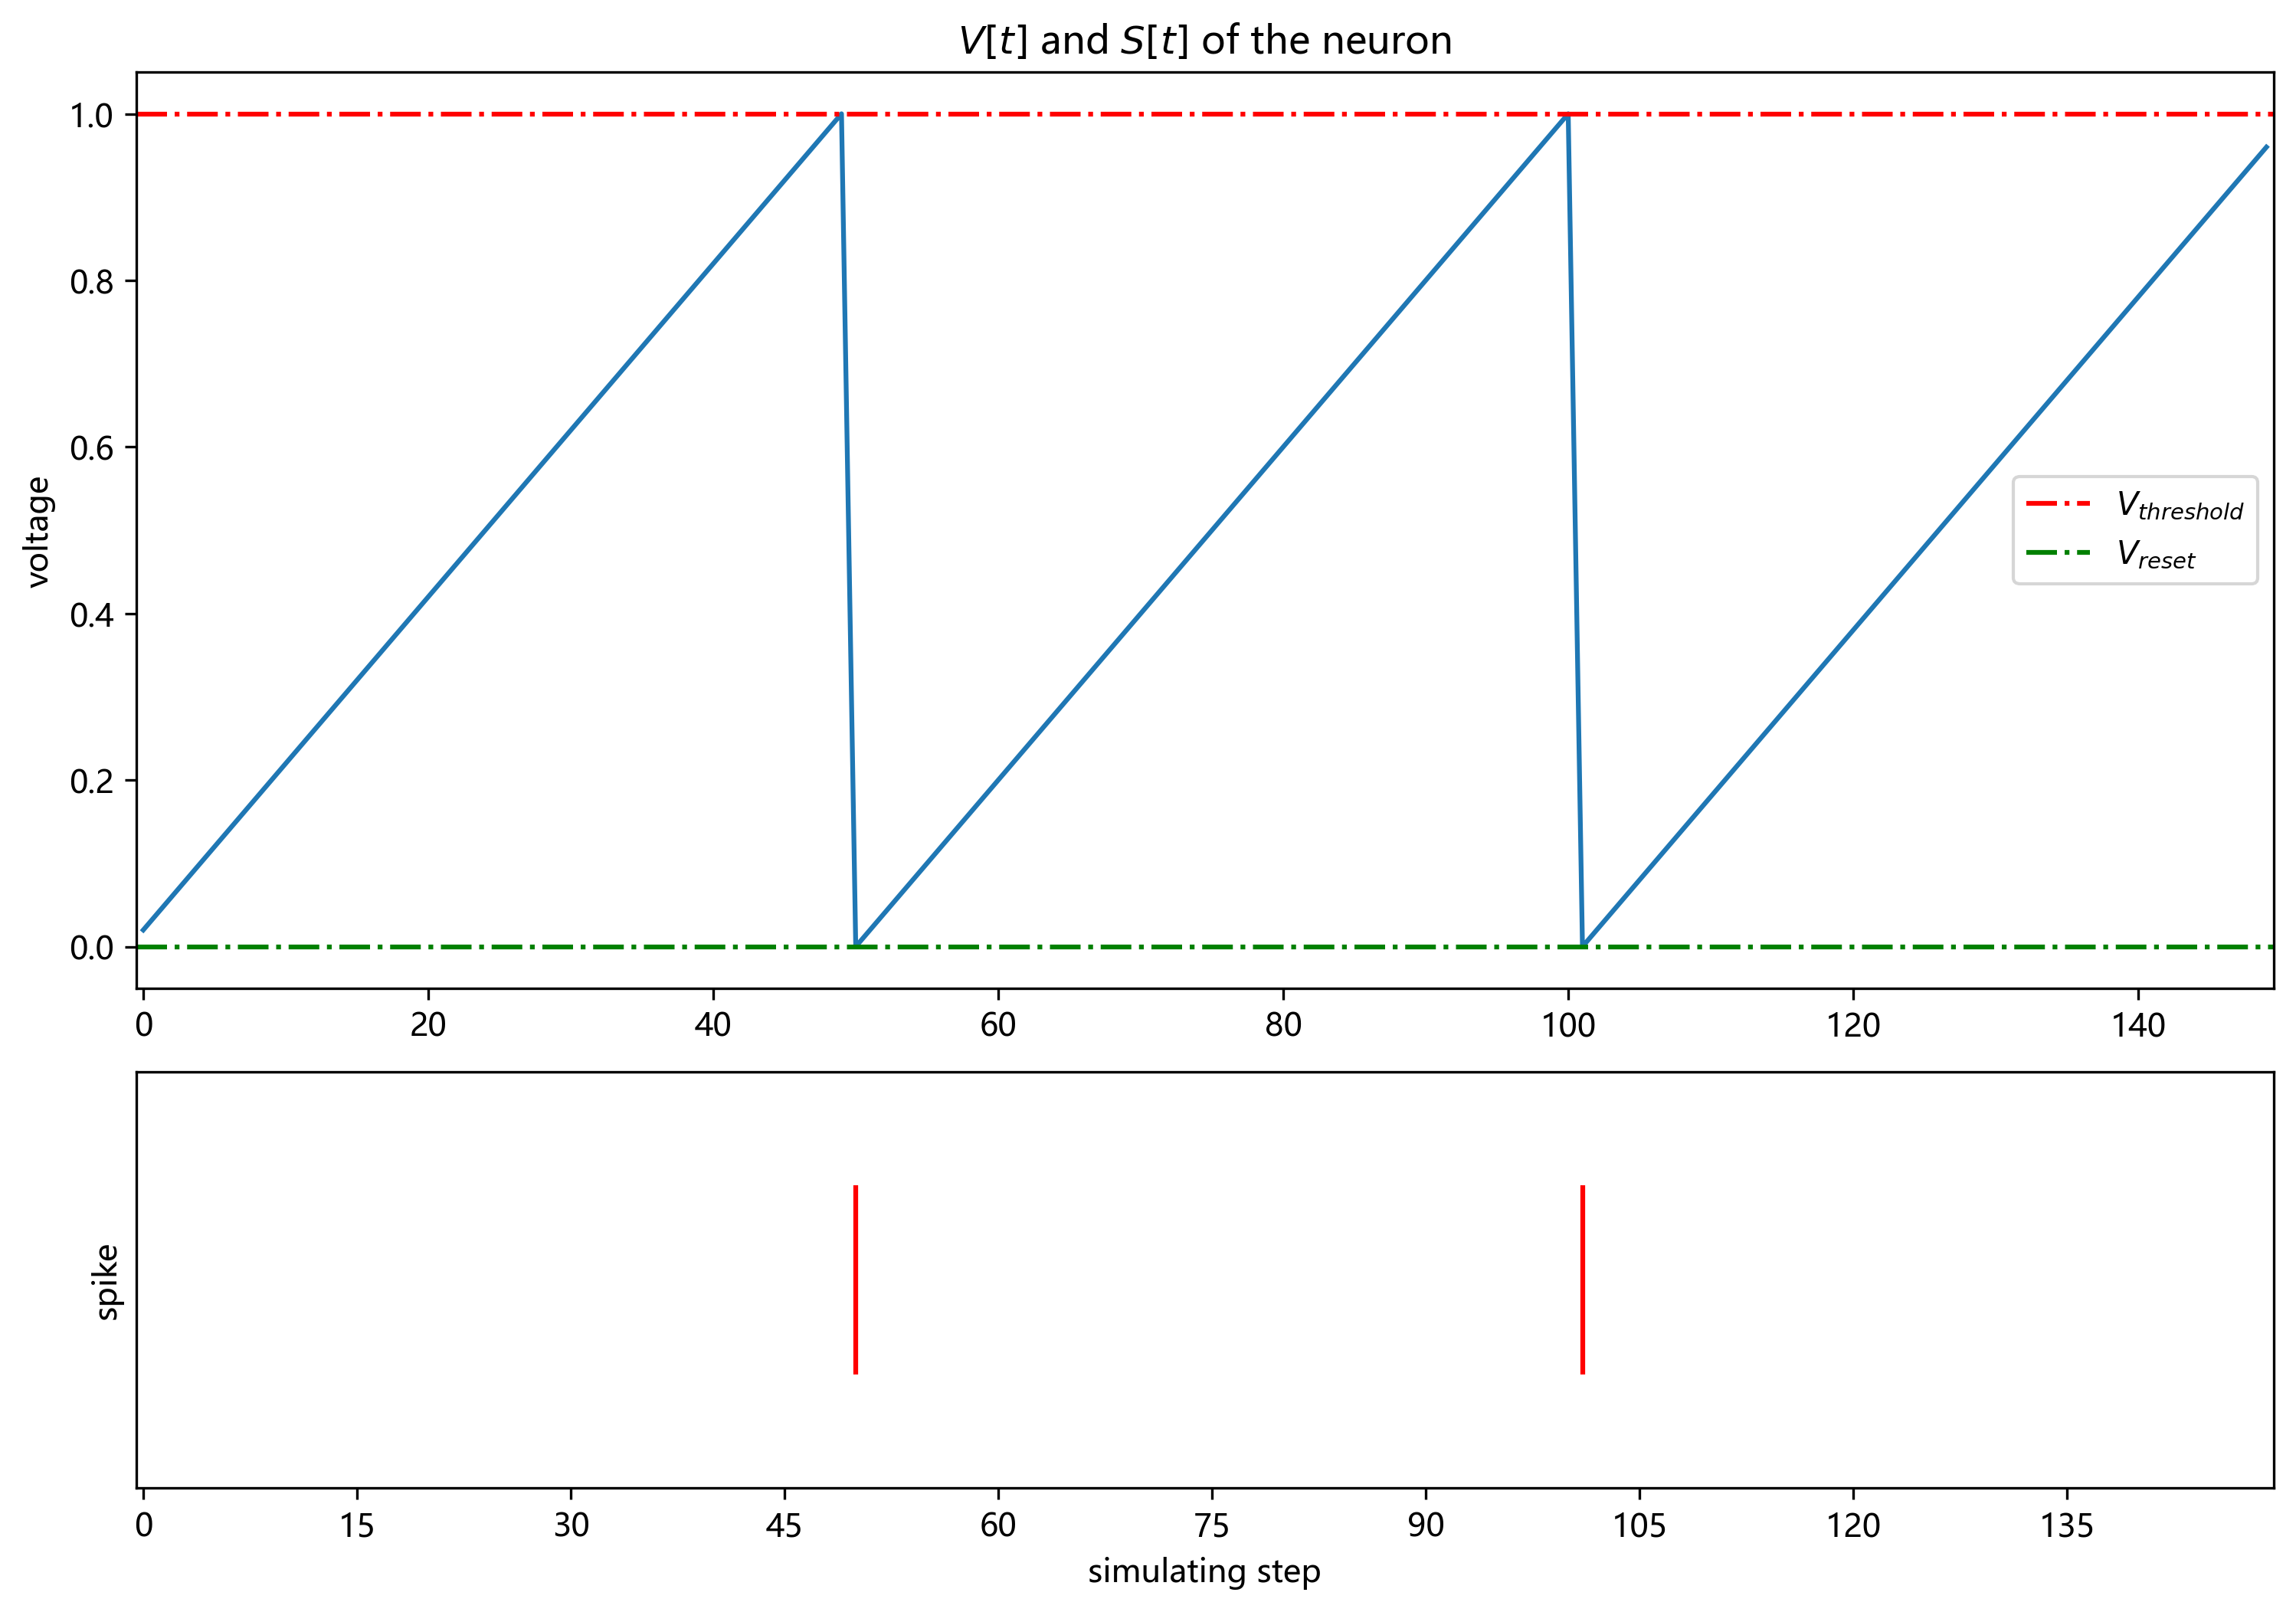

In [16]:
if_layer = neuron.IFNode()
x = torch.as_tensor([0.02])
T = 150
s_list = []
v_list = []
for t in range(T):
    s_list.append(if_layer(x))
    v_list.append(if_layer.v)
fig_size = (12, 8)
'''
plot_one_neuron(v: ndarray, s: ndarray, v_threshold: float = 1., v_reset: float = 0., title: str = "$V[t]$ and $S[t]$ of the neuron", figsize: tuple[int, int] = (12, 8), dpi: int = 200)
v: 神经元不同时刻的电压
s: 神经元不同时刻的释放的脉冲
dpi: 图像分辨率
'''
visualizing.plot_one_neuron_v_s(torch.cat(v_list).numpy(), torch.cat(s_list).numpy(), 
                                v_reset=if_layer.v_reset, figsize=fig_size, dpi=300)
plt.show()

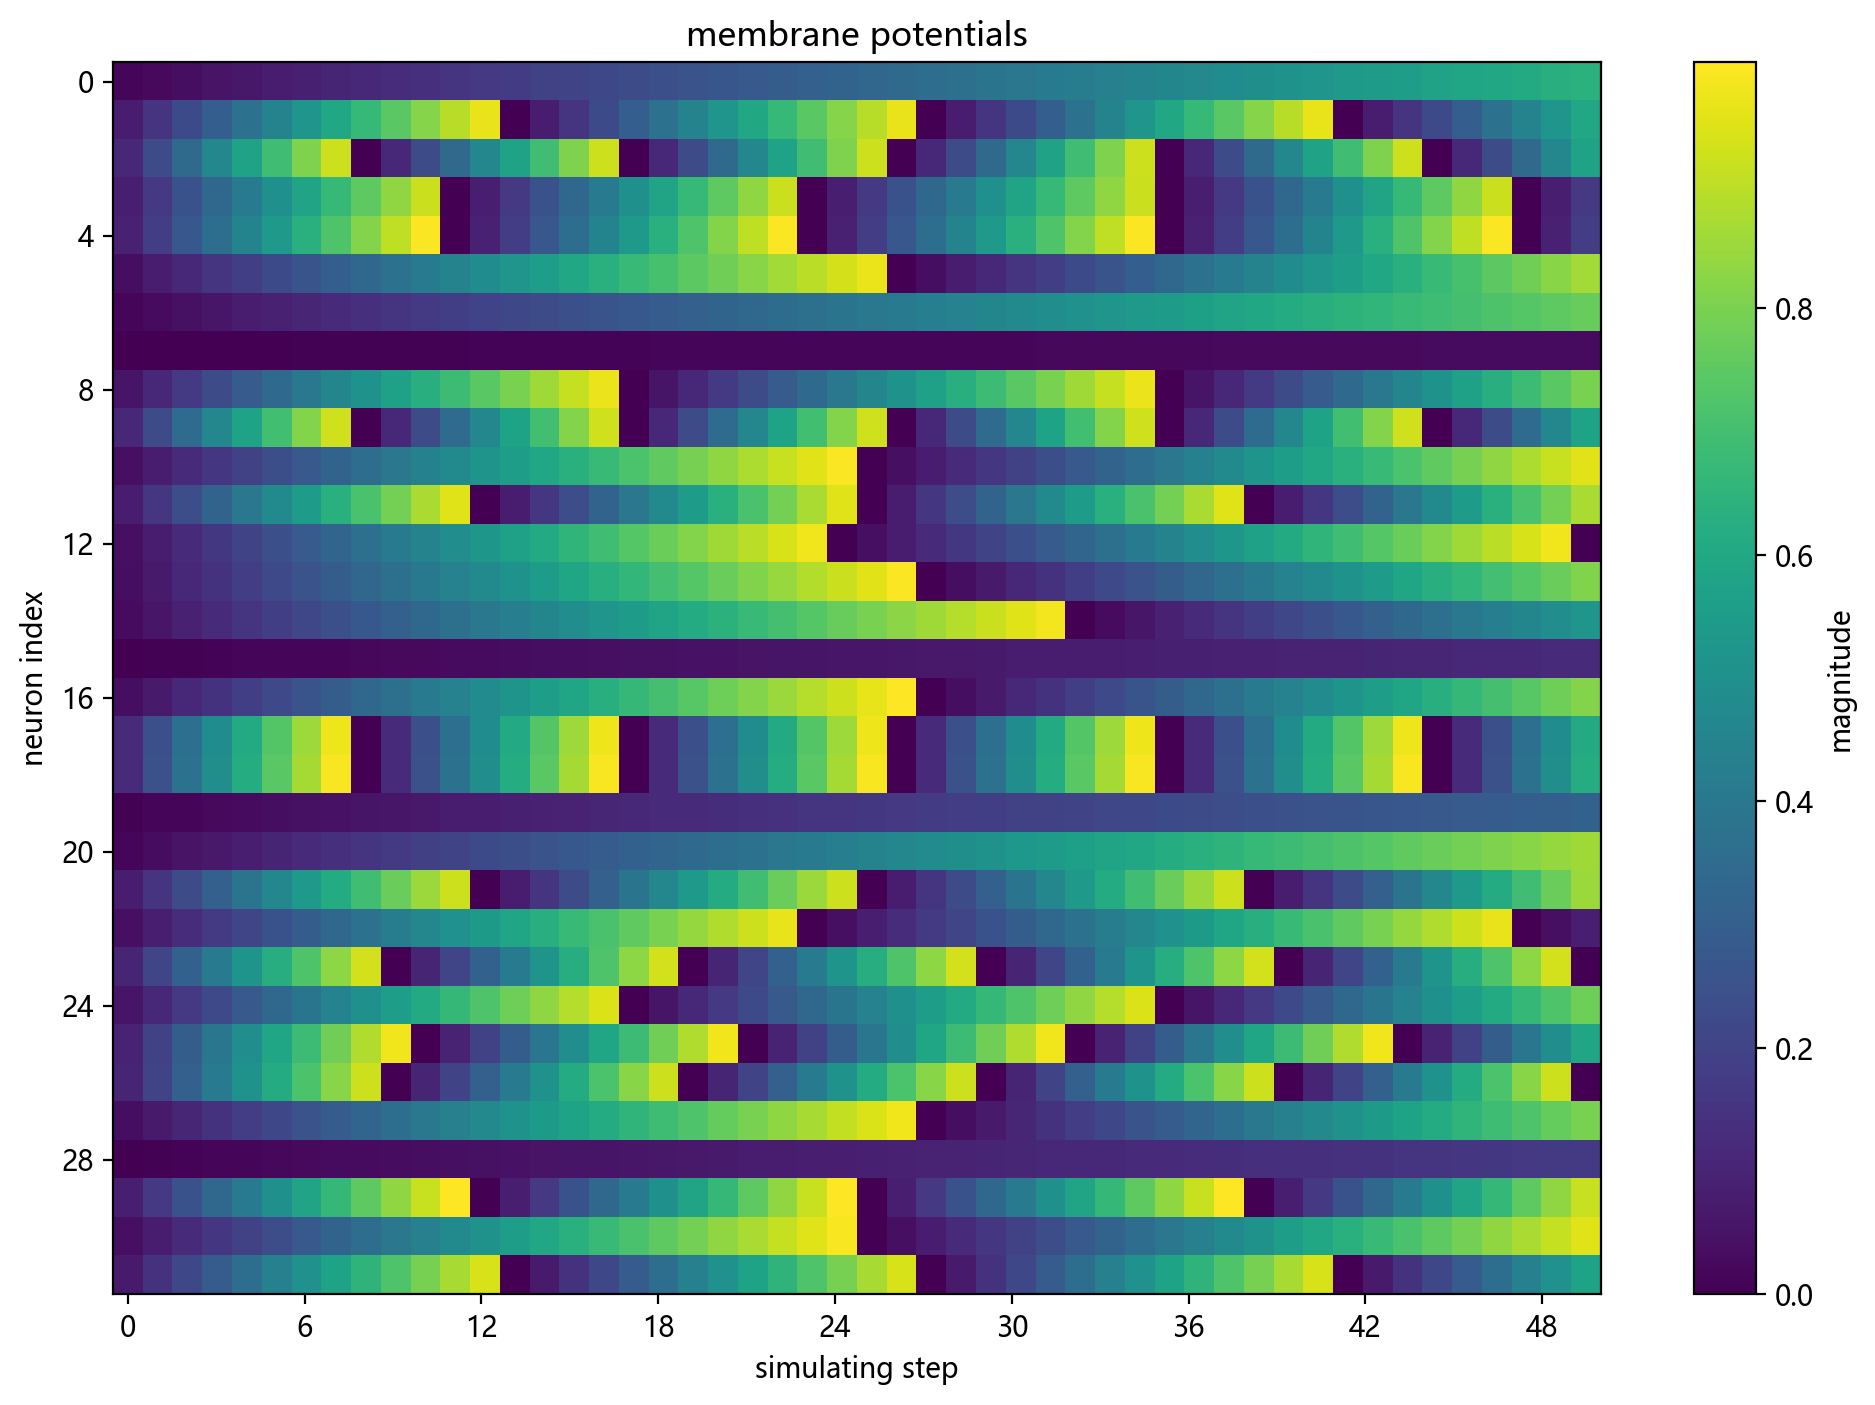

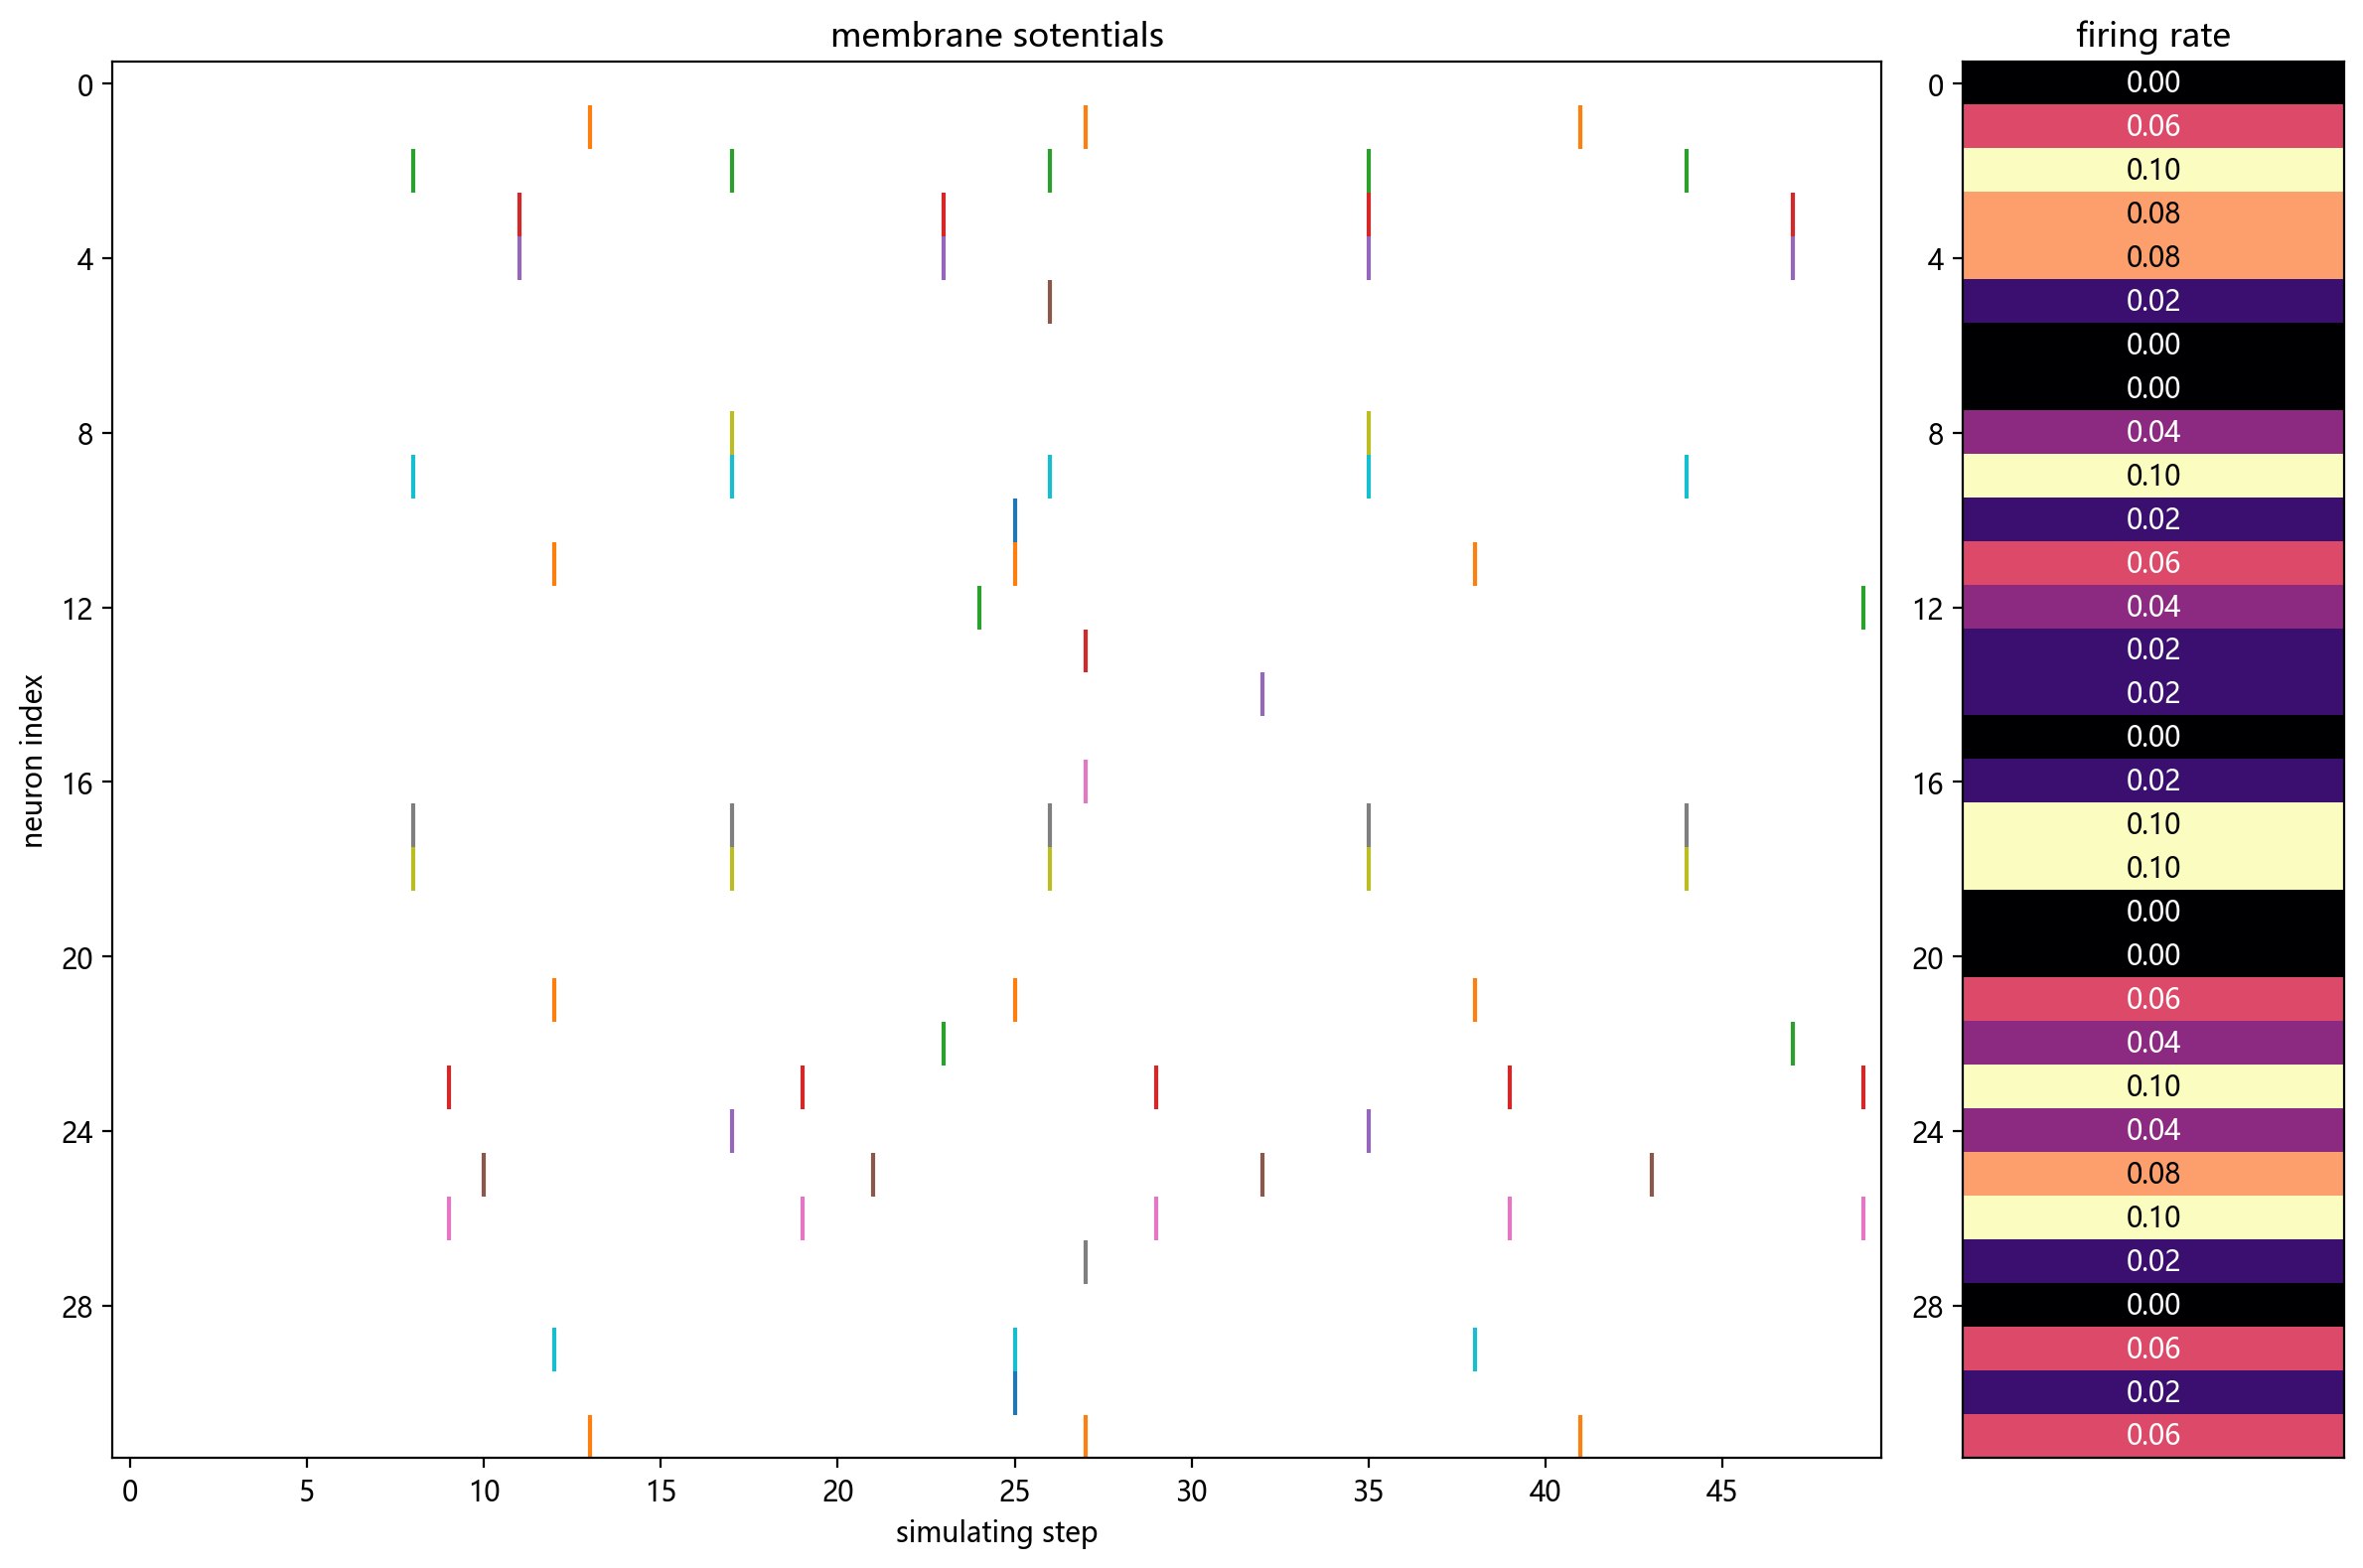

In [19]:
if_layer.reset()
T = 50
x = torch.rand([32]) / 8.
s_list = []
v_list = []
for t in range(T):
    s_list.append(if_layer(x).unsqueeze(0))
    v_list.append(if_layer.v.unsqueeze(0))
s_list = torch.cat(s_list)
v_list = torch.cat(v_list)
visualizing.plot_2d_heatmap(array=v_list.numpy(), title="membrane potentials", 
                            xlabel="simulating step", ylabel="neuron index", 
                            int_x_ticks=True, x_max=T, figsize=fig_size, dpi=200)
visualizing.plot_1d_spikes(spikes=s_list.numpy(), title="membrane sotentials",
                           xlabel="simulating step", ylabel="neuron index", 
                           figsize=fig_size, dpi=200)
plt.show()

### 3.4 后端

In [21]:
# 部分神经元在多步模式下支持 cupy 后端
if_layer = neuron.IFNode()
print(f'if_layer_backend={if_layer.backend}')
print(f'step_mode={if_layer.step_mode}, supported_backends={if_layer.supported_backends}')

if_layer.step_mode = 'm'
print(f'step_mode={if_layer.step_mode}, supported_backends={if_layer.supported_backends}')

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if_layer.to(device)
    if_layer.backend = 'cupy'
    print(f'if_layer_backend={if_layer.backend}')

x_seq = torch.rand([8, 4], device=device)
y_seq = if_layer(x_seq)
if_layer.reset()

if_layer_backend=torch
step_mode=s, supported_backends=('torch',)
step_mode=m, supported_backends=('torch', 'cupy')


### 3.5 自定义神经元

In [22]:
class SquareIFNode(neuron.BaseNode):
    def neuronal_charge(self, x: torch.Tensor):
        self.v = self.v + x ** 2

sif_layer = SquareIFNode()
T = 4
B = 1
x_seq = torch.rand([T, B])
print(f'x_seq={x_seq}')

for t in range(T):
    y_t = sif_layer(x_seq[t])
    print(f'sif_layer.v[{t}]={sif_layer.v}')
sif_layer.reset()

sif_layer.step_mode = 'm'
y_seq = sif_layer(x_seq)
print(f'y_seq={y_seq}')
sif_layer.reset()

x_seq=tensor([[0.0567],
        [0.4086],
        [0.6692],
        [0.6320]])
sif_layer.v[0]=tensor([0.0032])
sif_layer.v[1]=tensor([0.1702])
sif_layer.v[2]=tensor([0.6180])
sif_layer.v[3]=tensor([0.])
y_seq=tensor([[0.],
        [0.],
        [0.],
        [1.]])


## 4. 梯度替代
原理：在前向传播时，采用阶跃函数 $y=\Theta(x)$，而在反向传播时，使用 $\dfrac{\mathrm{d}y}{\mathrm{d}x}=\sigma^{\prime}(x)$ 而不是 $\dfrac{\mathrm{d}y}{\mathrm{d}x}=\Theta^{\prime}(x)$，其中 $\sigma(x)$ 即为替代函数(surrogate_function)。$\sigma(x)$ 通常是一个形状与 $\Theta(x)$ 类似，但连续光滑的函数。 

In [25]:
import torch
from spikingjelly.activation_based import surrogate

sg = surrogate.Sigmoid(alpha=4.)
x = torch.rand([8]) - 0.5
x.requires_grad = True
y = sg(x)
y.sum().backward()
print(f'x={x}\ny={y}\nx.grad={x.grad}')

x=tensor([ 0.3913, -0.3486,  0.4155,  0.4337, -0.1059, -0.3590,  0.3939,  0.2703],
       requires_grad=True)
y=tensor([1., 0., 1., 1., 0., 0., 1., 1.], grad_fn=<sigmoidBackward>)
x.grad=tensor([0.5721, 0.6368, 0.5362, 0.5100, 0.9564, 0.6209, 0.5682, 0.7566])


In [31]:
# 函数风格
x = torch.rand([8]) - 0.5
x.requires_grad = True
y = surrogate.sigmoid.apply(x, 4.)
y.sum().backward()
print(f'x={x}\ny={y}\nx.grad={x.grad}')

x=tensor([ 0.4273, -0.2636, -0.2609, -0.0609,  0.1110, -0.2226, -0.4438,  0.4371],
       requires_grad=True)
y=tensor([1., 0., 0., 0., 1., 0., 0., 1.], grad_fn=<sigmoidBackward>)
x.grad=tensor([0.5191, 0.7665, 0.7705, 0.9853, 0.9523, 0.8253, 0.4957, 0.5050])


## 5. 监视器：数据记录

### 5.1 基本使用

In [37]:
from spikingjelly.activation_based import monitor

net = nn.Sequential(
    layer.Linear(8, 4),
    neuron.IFNode(),
    layer.Linear(4, 2),
    neuron.IFNode(),
)

# 将权重全设置为正值，以避免无脉冲释放
for param in net.parameters():
    param.data.abs()

functional.set_step_mode(net, step_mode='m')

In [38]:
# 记录网络中所有 IFNode 的输出脉冲
spike_seq_monitor = monitor.OutputMonitor(net, neuron.IFNode)
T = 4
B = 1
x_seq = torch.rand([T, B, 8])

with torch.no_grad():
    net(x_seq)
print(f'spike_seq_monitor.records=\n{spike_seq_monitor.records}')

spike_seq_monitor.records=
[tensor([[[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 1.]],

        [[1., 0., 0., 0.]]]), tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]])]


In [39]:
# 可以使用下标访问
print(f'spike_seq_monitor.records[0]={spike_seq_monitor.records[0]}')

spike_seq_monitor.records[0]=tensor([[[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 1.]],

        [[1., 0., 0., 0.]]])


In [40]:
# 被监视器监控的层的名字
print(f'net={net}')
print(f'spike_seq_monitor.monitored_layers={spike_seq_monitor.monitored_layers}')

net=Sequential(
  (0): Linear(in_features=8, out_features=4, bias=True)
  (1): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
  (2): Linear(in_features=4, out_features=2, bias=True)
  (3): IFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
    (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
  )
)
spike_seq_monitor.monitored_layers=['1', '3']


In [41]:
# 可以使用名字作为索引
print(f"spike_seq_monitor['1']={spike_seq_monitor['1']}")

spike_seq_monitor['1']=[tensor([[[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 1.]],

        [[1., 0., 0., 0.]]])]


In [43]:
# 清空记录
spike_seq_monitor.clear_recorded_data()
print(f'spike_seq_monitor.records={spike_seq_monitor.records}')
print(f"spike_seq_monitor['1']={spike_seq_monitor['1']}")

spike_seq_monitor.records=[]
spike_seq_monitor['1']=[]


In [44]:
# 简单的数据处理
def cal_firing_rate(s_seq: torch.Tensor):
    """
    计算脉冲率
    :param s_seq: shape=[T, B, *]
    :return: 
    """
    return s_seq.flatten(1).mean(1)

fr_monitor = monitor.OutputMonitor(net, neuron.IFNode, cal_firing_rate)
with torch.no_grad():
    functional.reset_net(net)
    # 暂停记录
    fr_monitor.disable()
    net(x_seq)
    functional.reset_net(net)
    print(f'after call fr_monitor.disable(), fr_monitor.records=\n{fr_monitor.records}')
    # 重新开始记录
    fr_monitor.enable()
    net(x_seq)
    print(f'after call fr_monitor.enable(), fr_monitor.records=\n{fr_monitor.records}')
    functional.reset_net(net)
    del fr_monitor

after call fr_monitor.disable(), fr_monitor.records=
[]
after call fr_monitor.enable(), fr_monitor.records=
[tensor([0.0000, 0.0000, 0.2500, 0.2500]), tensor([0., 0., 0., 0.])]


### 5.2 记录模块成员变量

In [45]:
# 神经元构造函数中的 stroe_v_seq 默认为 False, 即默认不记录电压序列。现将其设置为 True
for m in net.modules():
    if isinstance(m, neuron.IFNode):
        m.store_v_seq = True

v_seq_monitor = monitor.AttributeMonitor('v_seq', pre_forward=False, net=net, instance=neuron.IFNode)
with torch.no_grad():
    net(x_seq)
    print(f'v_seq_monitor.records=\n{v_seq_monitor.records}')
    functional.reset_net(net)
    del v_seq_monitor

v_seq_monitor.records=
[tensor([[[ 0.1286, -0.8360,  0.0093,  0.5831]],

        [[ 0.3789, -1.3688,  0.1503,  0.8486]],

        [[ 0.8817, -1.8571,  0.3047,  0.0000]],

        [[ 0.0000, -2.3196,  0.3784,  0.5197]]]), tensor([[[ 0.0302, -0.4113]],

        [[ 0.0605, -0.8226]],

        [[ 0.4487, -0.7755]],

        [[ 0.4253, -1.5973]]])]


### 5.3 记录模块输入

In [46]:
input_monitor = monitor.InputMonitor(net, neuron.IFNode)
with torch.no_grad():
    net(x_seq)
    print(f'input_monitor.records=\n{input_monitor.records}')
    functional.reset_net(net)
    del input_monitor

input_monitor.records=
[tensor([[[ 0.1286, -0.8360,  0.0093,  0.5831]],

        [[ 0.2503, -0.5328,  0.1410,  0.2655]],

        [[ 0.5028, -0.4883,  0.1543,  0.4284]],

        [[ 0.1326, -0.4625,  0.0737,  0.5197]]]), tensor([[[ 0.0302, -0.4113]],

        [[ 0.0302, -0.4113]],

        [[ 0.3883,  0.0470]],

        [[-0.0234, -0.8218]]])]


### 5.4 记录模块的输入梯度

In [47]:
spike_seq_grad_monitor = monitor.GradInputMonitor(net, neuron.IFNode)
net(x_seq).sum().backward()
print(f'spike_seq_grad_monitor.records=\n{spike_seq_grad_monitor.records}')
functional.reset_net(net)
del spike_seq_grad_monitor

spike_seq_grad_monitor.records=
[tensor([[[7.9945e-01, 2.0218e-02]],

        [[7.2182e-01, 6.1436e-03]],

        [[6.3614e-01, 3.4112e-03]],

        [[3.3163e-01, 1.2302e-04]]]), tensor([[[-4.9598e-02, -6.8011e-04, -2.5751e-02,  3.4088e-01]],

        [[-4.4350e-02, -7.1943e-05, -2.1686e-02,  2.6582e-01]],

        [[-3.6568e-02, -8.5265e-06, -1.5726e-02,  1.2072e-01]],

        [[-1.7827e-02, -6.4080e-07, -6.4932e-03,  5.2942e-02]]])]


### 5.5 记录模块的输出梯度

In [48]:
# 调节替代函数的 alpha 值，并比较不同 alpha 值下的梯度的幅值
net =[]
for i in range(10):
    net.append(layer.Linear(8, 8))
    net.append(neuron.IFNode())
net = nn.Sequential(*net)

functional.set_step_mode(net, step_mode='m')
T = 4
B = 1
x_seq = torch.rand([T, B, 8])

input_grad_monitor = monitor.GradInputMonitor(net, neuron.IFNode, function_on_grad_input=torch.norm)

for alpha in [0.1, 0.5, 2, 4, 8]:
    for m in net.modules():
        if isinstance(m, surrogate.Sigmoid):
            m.alpha = alpha
    net(x_seq).sum().backward()
    print(f'alpha={alpha}, input_grad_monitor.records=\n{input_grad_monitor.records}')
    functional.reset_net(net)
    for param in net.parameters():
        param.grad.zero_()
    
    input_grad_monitor.records.clear()

alpha=0.1, input_grad_monitor.records=
[tensor(0.3740), tensor(0.0071), tensor(0.0002), tensor(5.0793e-06), tensor(8.2031e-08), tensor(1.5418e-09), tensor(3.4174e-11), tensor(5.2256e-13), tensor(1.1116e-14), tensor(2.8747e-16)]
alpha=0.5, input_grad_monitor.records=
[tensor(1.7181), tensor(0.1491), tensor(0.0215), tensor(0.0023), tensor(0.0002), tensor(1.4284e-05), tensor(1.5348e-06), tensor(1.3178e-07), tensor(1.2260e-08), tensor(1.5638e-09)]
alpha=2, input_grad_monitor.records=
[tensor(3.6131), tensor(0.7721), tensor(0.2858), tensor(0.0644), tensor(0.0147), tensor(0.0035), tensor(0.0008), tensor(0.0002), tensor(2.1364e-05), tensor(7.9809e-06)]
alpha=4, input_grad_monitor.records=
[tensor(4.2961), tensor(1.3316), tensor(0.5603), tensor(0.1766), tensor(0.0299), tensor(0.0103), tensor(0.0038), tensor(0.0013), tensor(0.0002), tensor(9.3426e-05)]
alpha=8, input_grad_monitor.records=
[tensor(5.9032), tensor(2.8379), tensor(1.4795), tensor(0.6847), tensor(0.1819), tensor(0.0531), tensor(0.0